# Second dose first day with respect to first dose efficacy

In [1]:
import os
import os.path
import pandas as pd
import numpy as np
import datetime
import itertools
import matplotlib.pylab as plt
from matplotlib import rc
rc("text", usetex=True)
rc("font", family="serif")

import run_robot
import prepare_data
from importlib import reload
reload(prepare_data)
reload(run_robot)
from julia import Main as Julia 

Loading modules...
Loading modules... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading modules...
Loading modules... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!


In [2]:
# Define the basic data for the case studies

# Mean incubation time
tinc = 5.2

# Mean inffectious time
tinf = 2.9

# Basic reproduction number
basic_rep = 2.5

# Lockdown level
lock_level = 1.0

# Simulation horizon
# A little more than a year when thevaccine should be here
ndays = 7*52

# Mean time in ICU
time_icu = 7

# Transmission/infection effect of the vaccine - Oxford profile
vaccine_atten = [1.0, 0.24, 0.176]
# Transmission/infection effect of the vaccine - Pfizer profile
# vaccine_atten = [1.0, 0.15, 0.05]

# R0 factor for each population
r0pop = [1.0, 1.3, 1.0, 1.0]

# Max dose profile
max_doses = 0.01*np.ones(ndays)
max_doses[:150] = np.linspace(0.001, 0.01, 150)
# max_doses[:130] = 0.003
# max_doses[130:150] = np.linspace(0.003, 0.01, 20)

# Doses window
doses_min_window, doses_max_window = [28], [84]

# Define basic paramters
basic_prm = prepare_data.save_basic_parameters(tinc=tinc, tinf=tinf, rep=basic_rep, min_level=lock_level,
    time_icu=time_icu, alternate=0, window=14, ndays=ndays)

pre_cities_data = {
    "S1": [0.685], 
    "E1": [0.01], 
    "I1": [0.006], 
    "R1": [0.299], 
    "population": [44639899], 
    "icu_capacity": [0.000175], 
    "start_date": [pd.to_datetime("2020-2-1")]
}
cities_data = pd.DataFrame(pre_cities_data, index=["SP"])
cities_data

,S1,E1,I1,R1,population,icu_capacity,start_date
SP,0.685,0.01,0.006,0.299,44639899,0.000175,2020-02-01


In [3]:
# Create a target matrix (max infected level)
ncities, ndays = len(cities_data.index), int(basic_prm["ndays"])
target = np.ones((ncities, ndays))
target = prepare_data.save_target(cities_data, target)

# Use a forcedif that releases the cities in the end
force_dif = np.zeros((ncities, ndays))

In [4]:
# Add information on the time series that estimate the need of ICUs
# We are using the time series adjusted considering that the mean ICU stay is 7 days (which lead to larger ICU capacity).

# Define the time series to estimate ICU demand
ts_sp = np.array([0.009, 0.015, 0.492, 0.0, 0.0, 0.0, 0.083, 0.011, 0.011])

ts_drs = ts_sp*np.ones((len(cities_data), len(ts_sp)))
ts_drs = pd.DataFrame(data=ts_drs, index=cities_data.index, columns=[
    "rho_min", "rho_max", "intercept", "trend", "phi_1", "phi_2", "sigma_omega", "state0", "state_less_1"
])
ts_drs["confidence"] = 0.95
ts_drs["time_icu"] = time_icu
cities_data = pd.concat([cities_data, ts_drs], axis=1)
cities_data

,S1,E1,I1,R1,population,icu_capacity,start_date,rho_min,rho_max,intercept,trend,phi_1,phi_2,sigma_omega,state0,state_less_1,confidence,time_icu
SP,0.685,0.01,0.006,0.299,44639899,0.000175,2020-02-01,0.009,0.015,0.492,0.0,0.0,0.0,0.083,0.011,0.011,0.95,7


In [5]:
pd.set_option("display.width", 120)

# Simple function to run a test and save results
def run_a_test(basic_prm, result_file, figure_file, cities_data, M, target, force_dif, r0pop, r_atten, icu_atten, 
    max_doses, doses_min_window, doses_max_window, verbosity=1):
    run_robot.prepare_optimization(basic_prm, cities_data, M, target, hammer_data, force_dif,
        r0pop, r_atten, icu_atten, max_doses, doses_min_window, doses_max_window, verbosity=verbosity)
    run_robot.optimize_and_show_results(basic_prm, figure_file, result_file, cities_data, target, verbosity=verbosity)

In [6]:
# Define mobility matrix.
M = prepare_data.convert_mobility_matrix_and_save(cities_data, max_neighbors=5, drs="data/report_drs_mobility.csv")
hammer_data = prepare_data.save_hammer_data(cities_data, 0, basic_prm["min_level"])
run_robot.find_feasible_hammer(basic_prm, cities_data, M, target, hammer_data, out_file=None, 
    incr_all=True, verbosity=1)
hammer_data["duration"] = 14
M

Checking if initial hammer is long enough...

Number of iterations: 2
Total time: 0.12246474000858143 s

Hammer data
    duration  level
SP        14    1.0
Checking if initial hammer is long enough... Ok!


,SP,out
SP,0.0,0.0


In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def agregate(solution, labels):
    values = solution.loc[labels[0]].sum()
    for i in range(1, len(labels)):
        values += solution.loc[labels[i]].sum()
    return values


def retrieve_vaccination_profile(sol, pop=0, dose=0):
    sol = sol.loc[:, pop, :]
    seir = sol.loc["s", :] + sol.loc["e", :] + sol.loc["i", :] + sol.loc["r", :]
    applied = sol.loc["v", dose]*seir.loc[dose]
    return applied[14:]


def mean_window(result_file, horizon=350, d1_threshold=0.9, nsubs=4):
    solution = pd.read_csv(result_file, index_col=[0, 1, 2])

    # Compute the doses as proportions of the population
    total_dose1 = retrieve_vaccination_profile(solution, 0, 0)
    for i in range(1, nsubs):
        total_dose1 += retrieve_vaccination_profile(solution, i, 0)
    total_dose2 = retrieve_vaccination_profile(solution, 0, 1)
    for i in range(1, nsubs):
        total_dose2 += retrieve_vaccination_profile(solution, i, 1)
    cum1 = total_dose1.cumsum()
    cum2 = total_dose2.cumsum()

    mean, weights = 0.0, 0.0
    for i in range(horizon):
        weight = total_dose1[i]
        window = (cum2 >= cum1[i]).argmax() - i
        if window <= 0 or cum1[i + window] >= d1_threshold:
            break
        mean += weight*window
        weights += weight
    return mean / weights


def alt_opt(basic_prm, result_file, figure_file, cities_data, M, target, force_dif, r0pop, 
    r_atten, icu_atten, max_doses, doses_min_window, doses_max_window):

    if os.path.exists("./profile_data.csv"):
        os.unlink("./profile_data.csv")
    
    run_a_test(basic_prm, "./profile_data.csv", "/tmp/erase", cities_data, M, target, force_dif, 
        r0pop, r_atten, icu_atten, max_doses, doses_min_window, doses_max_window)
    if not Julia.opt_OK:
        if os.path.exists("./profile_data.csv"):
            os.unlink("./profile_data.csv")
        return False

    run_a_test(basic_prm, result_file, figure_file, cities_data, M, target, force_dif, 
        r0pop, r_atten, icu_atten, max_doses, doses_min_window, doses_max_window)
    if os.path.exists("./profile_data.csv"):
        os.unlink("./profile_data.csv")
    if not Julia.opt_OK:
        return False
    
    return True


def med_mean_window(result_file, sub_window=7, horizon=350, d1_threshold=0.9, nsubs=4):
    solution = pd.read_csv(result_file, index_col=[0, 1, 2])

    # Compute the doses as proportions of the population
    total_dose1 = retrieve_vaccination_profile(solution, 0, 0)
    for i in range(1, nsubs):
        total_dose1 += retrieve_vaccination_profile(solution, i, 0)
    total_dose2 = retrieve_vaccination_profile(solution, 0, 1)
    for i in range(1, nsubs):
        total_dose2 += retrieve_vaccination_profile(solution, i, 1)
    cum1 = total_dose1.cumsum()
    cum2 = total_dose2.cumsum()

    movavg = []
    for k in range(horizon - sub_window):
        mean, weights = 0.0, 0.0
        for i in range(k, k + sub_window):
            weight = total_dose1[i]
            window = (cum2 >= cum1[i]).argmax() - i
            if window <= 0 or cum1[i + window] >= d1_threshold:
                break
            mean += weight*window
            weights += weight
        if weights > 0.0:
            movavg.append(mean / weights)
    return np.median(movavg)



## With vaccination blocking infection

******************** Running vaccine simulation
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
1.3 : (0.0, 29.0)


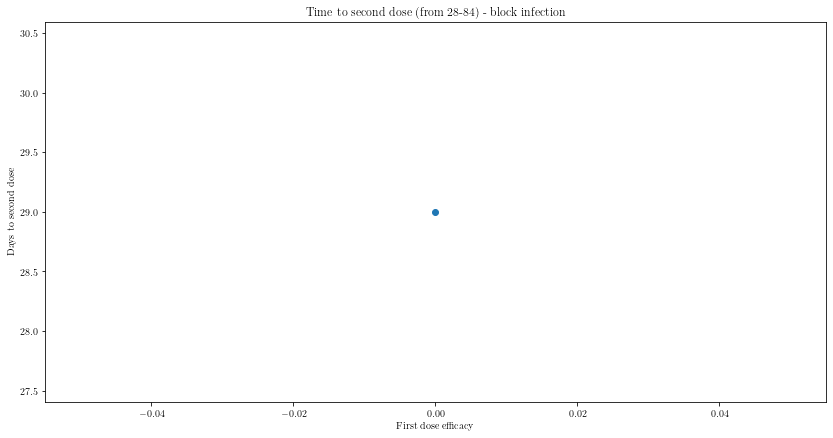

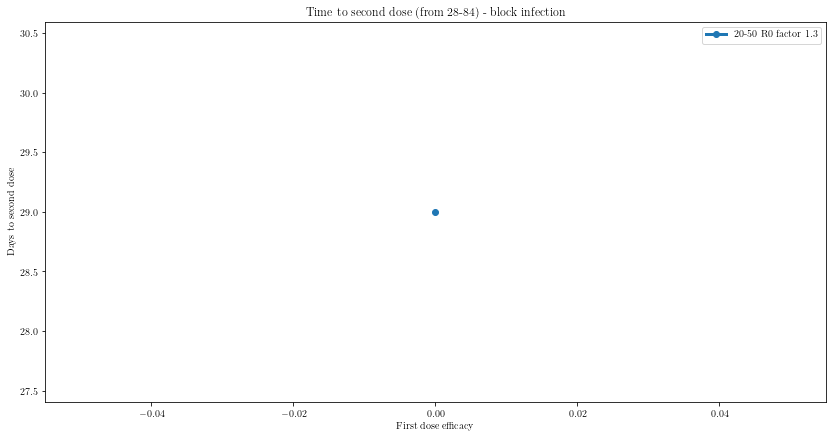

In [28]:
print("******************** Running vaccine simulation")
r_atten = vaccine_atten
icu_atten = [1.0, 1.0, 1.0]

bins = [[0, 19], [20, 49], [50, 64], [65, 200]]
figure_all_file = "results/efficacy_sensitivity_infection_R0_20_49_all.svg"
figure_all = plt.figure()

basic_prm["alternate"] = 0.0
for difr0 in [1.3]: #np.linspace(1, 1.6, 7):
    r0pop[1] = difr0
    dose_delay = []
    for atten in np.linspace(1.0, 0.20, 17):
        r_atten[1] = atten
        figure_file = f"results/efficacy_sensitivity_infection_R0_20_49_{difr0:.2f}"
        result_file =  figure_file + f"_atten_{atten:.2f}.csv"
        opt_ok = alt_opt(basic_prm, result_file, figure_file, cities_data, M, target, 
            force_dif, r0pop, r_atten, icu_atten, max_doses, doses_min_window, doses_max_window)
        if not opt_ok:
            print("Problem in optimization for", r0pop, r_atten)
            print("Living result out of plot")
            continue

        dose_delay.append((100*(1.0 - atten), med_mean_window(result_file)))
        print(r0pop[1], ":", dose_delay[-1])
    dose_delay = np.array(dose_delay).T
    plt.figure()
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3)
    plt.xlabel("First dose efficacy")
    plt.ylabel("Days to second dose")
    plt.title("Time to second dose (from 28-84) - block infection")
    plt.axis("tight")
    plt.savefig(figure_file + ".svg")
    plt.figure(figure_all.number)
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3, label=f"20-50 R0 factor {difr0:.1f}")
plt.xlabel("First dose efficacy")
plt.ylabel("Days to second dose")
plt.title("Time to second dose (from 28-84) - block infection")
plt.legend()
plt.axis("tight")
plt.savefig(figure_all_file)

## With vaccination decreasing symptoms

******************** Running vaccine simulation
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
1.3 : (0.0, 29.000000000000004)
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
1.3 : (5.000000000000004, 29.000000000000004)
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
1.3 : (9.999999999999998, 29.0)
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
Solving Robot-dance...
Solving Robot-dance... Ok!
Saving output files...
Saving output files... Ok!
1.3 : (15.000000000000002, 29.000000000000

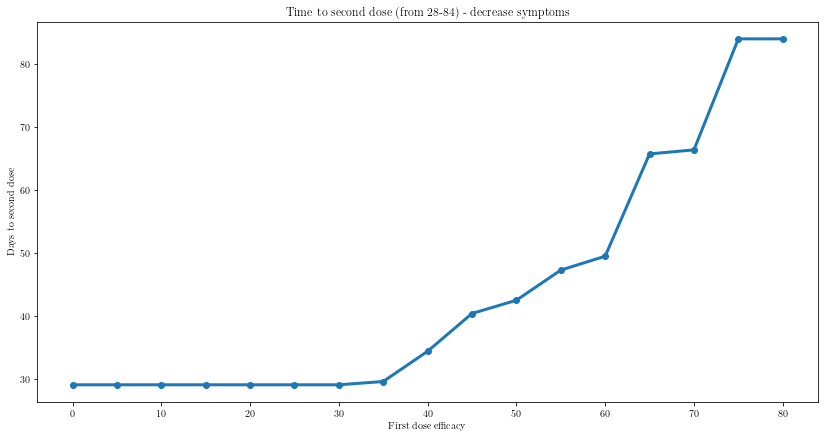

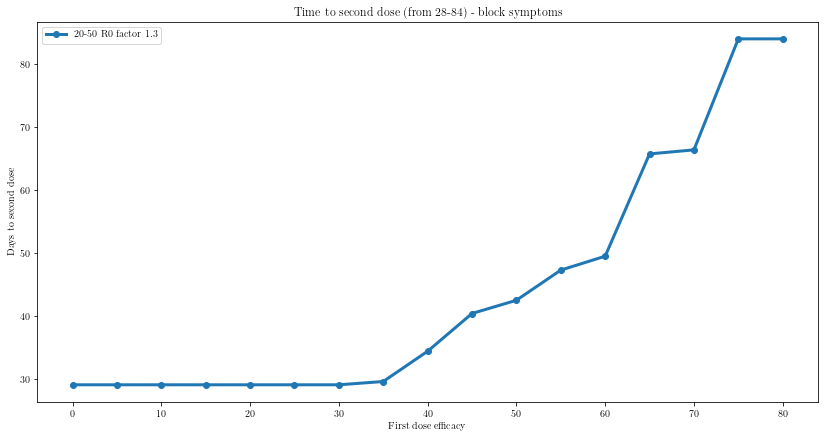

In [9]:
print("******************** Running vaccine simulation")
r_atten = [1.0, 1.0, 1.0]
icu_atten = vaccine_atten

bins = [[0, 19], [20, 49], [50, 64], [65, 200]]
figure_all_file = "results/efficacy_sensitivity_symptoms_R0_20_49_all.svg"
figure_all = plt.figure()

basic_prm["alternate"] = 0.0
for difr0 in [1.3]: #np.linspace(1, 1.6, 7):
    r0pop[1] = difr0
    dose_delay = []
    for atten in np.linspace(1.0, 0.20, 17):
        icu_atten[1] = atten
        figure_file = f"results/efficacy_sensitivity_symptoms_R0_20_49_{difr0:.2f}"
        result_file =  figure_file + f"_atten_{atten:.2f}.csv"

        opt_ok = alt_opt(basic_prm, result_file, figure_file, cities_data, M, target, 
            force_dif, r0pop, r_atten, icu_atten, max_doses, doses_min_window, doses_max_window)
        if not opt_ok:
            print("Problem in optimization for", r0pop, r_atten)
            print("Living result out of plot")
            continue

        dose_delay.append((100*(1.0 - atten), med_mean_window(result_file)))
        print(r0pop[1], ":", dose_delay[-1])
    plt.figure()
    dose_delay = np.array(dose_delay).T
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3)
    plt.xlabel("First dose efficacy")
    plt.ylabel("Days to second dose")
    plt.title("Time to second dose (from 28-84) - decrease symptoms")
    plt.axis("tight")
    plt.savefig(figure_file + ".svg")
    plt.figure(figure_all.number)
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3, label=f"20-50 R0 factor {difr0:.1f}")
plt.xlabel("First dose efficacy")
plt.ylabel("Days to second dose")
plt.title("Time to second dose (from 28-84) - block symptoms")
plt.legend()
plt.axis("tight")
plt.savefig(figure_all_file)


In [10]:
result_file = "results/efficacy_sensitivity_infection_R0_20_49_1.30_atten_0.25.csv"
mean_window(result_file, horizon=340)

83.90104913161709

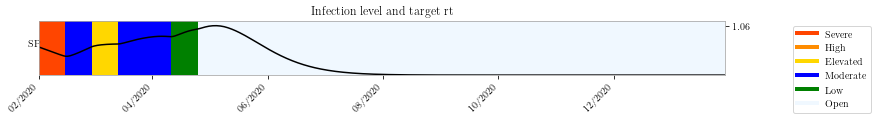

In [11]:
def agregate(solution, labels):
    values = solution.loc[labels[0]].sum()
    for i in range(1, len(labels)):
        values += solution.loc[labels[i]].sum()
    return values

solution = pd.read_csv(result_file, index_col=[0, 1, 2])

i = agregate(solution, ["i", "ir"])
rt = solution.loc["rt", -1, -1]
run_robot.plot_result("SP", basic_prm, rt, i, hammer_data["duration"], start_date="2020-02-01")


Text(0.5, 1.0, 'Vaccination')

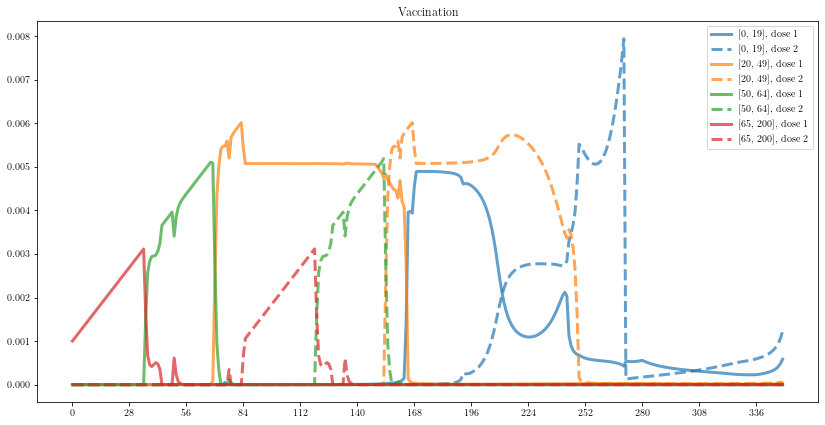

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

bins = [[0, 19], [20, 49], [50, 64], [65, 200]]
colors = ["C0", "C1", "C2", "C3"]

def retrieve_vaccination_profile(sol, pop=0, dose=0):
    sol = sol.loc[:, pop, :]
    seir = sol.loc["s", :] + sol.loc["e", :] + sol.loc["i", :] + sol.loc["r", :]
    applied = sol.loc["v", dose]*seir.loc[dose]
    return applied[14:]

for i in range(len(bins)):
    retrieve_vaccination_profile(solution, i, 0).plot(lw=3, color=colors[i], alpha=0.7, label=f"{bins[i]}, dose 1")
    retrieve_vaccination_profile(solution, i, 1).plot(lw=3, alpha=0.7, color=colors[i], ls="--", label=f"{bins[i]}, dose 2")
ticks = range(0, solution.loc["s", 0, 0, :].shape[1], 28)
plt.xticks(ticks, ticks)
plt.legend()
plt.title("Vaccination")

Total doses 1.9825095942814026


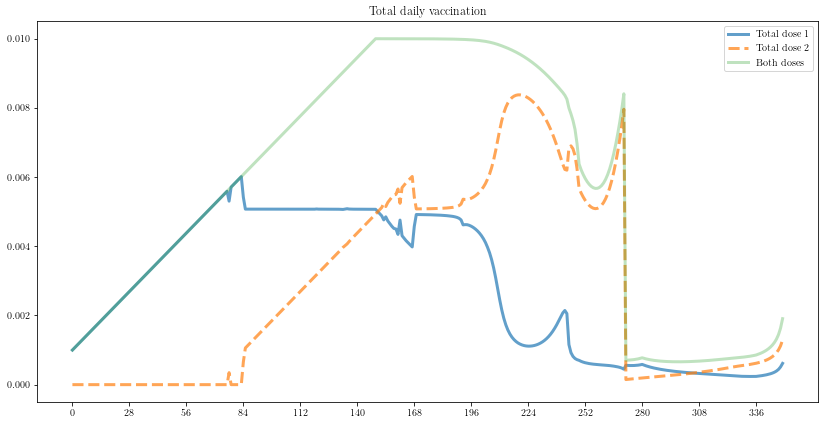

In [13]:
total_dose1 = retrieve_vaccination_profile(solution, 0, 0)
for i in range(1, len(bins)):
    total_dose1 += retrieve_vaccination_profile(solution, i, 0)
total_dose2 = retrieve_vaccination_profile(solution, 0, 1)
for i in range(1, len(bins)):
    total_dose2 += retrieve_vaccination_profile(solution, i, 1)
total_dose1.plot(lw=3, alpha=0.7, label="Total dose 1")
total_dose2.plot(lw=3, ls="--", alpha=0.7, label="Total dose 2")
both = total_dose1 + total_dose2 
both.plot(lw=3, alpha=0.3, label="Both doses")
plt.xticks(ticks, ticks)
plt.legend()
plt.title("Total daily vaccination");
print("Total doses", sum(both))

In [14]:
solution = pd.read_csv(result_file, index_col=[0, 1, 2])
nsubs = 4 

# Compute the doses as proportions of the population
total_dose1 = retrieve_vaccination_profile(solution, 0, 0)
for i in range(1, nsubs):
    total_dose1 += retrieve_vaccination_profile(solution, i, 0)
total_dose2 = retrieve_vaccination_profile(solution, 0, 1)
for i in range(1, nsubs):
    total_dose2 += retrieve_vaccination_profile(solution, i, 1)
cum1 = total_dose1.cumsum()
cum2 = total_dose2.cumsum()


In [15]:
cum1, cum2 = cum1.values, cum2.values


[[ 0.          5.         10.         15.         20.         25.
  30.         35.         40.         45.         50.         55.
  60.         65.         70.         75.         80.        ]
 [29.         29.         29.         29.         29.         29.
  29.00001348 29.54218266 34.68634664 44.08350197 45.50203646 48.03871663
  49.49715987 63.80349572 64.87780125 84.         84.        ]]
[[ 0.          5.         10.         15.         20.         25.
  30.         35.         40.         50.         55.         60.
  65.         70.         75.         80.        ]
 [29.         29.         29.         29.         29.         29.
  29.         29.         29.32461929 55.27198366 72.12439839 73.70862115
  83.99950129 83.9975748  84.         84.        ]]


(-4.0, 84.0, 26.25, 86.75)

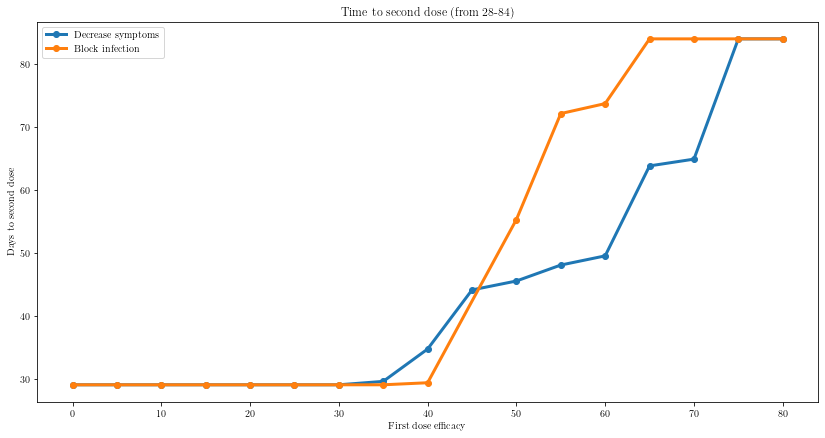

In [27]:
r_atten = [1.0, 1.0, 1.0]
icu_atten = vaccine_atten

bins = [[0, 19], [20, 49], [50, 64], [65, 200]]
figure_all_file = "results/efficacy_sensitivity_infection_R0_20_49_all.svg"
figure_all = plt.figure()

basic_prm["alternate"] = 0.0
for difr0 in [1.3]: #np.linspace(1, 1.6, 7):
    r0pop[1] = difr0
    dose_delay = []
    for atten in np.linspace(1.0, 0.20, 17):
        icu_atten[1] = atten
        figure_file = f"results/efficacy_sensitivity_symptoms_R0_20_49_{difr0:.2f}"
        result_file =  figure_file + f"_atten_{atten:.2f}.csv"
        if os.path.exists(result_file):
            dose_delay.append((100*(1.0 - atten), med_mean_window(result_file, sub_window=7, d1_threshold=0.95)))
    dose_delay = np.array(dose_delay).T
    print(dose_delay)
    plt.figure(figure_all.number)
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3, label=f"Decrease symptoms")

basic_prm["alternate"] = 0.0
for difr0 in [1.3]: #np.linspace(1, 1.6, 7):
    r0pop[1] = difr0
    dose_delay = []
    for atten in np.linspace(1.0, 0.20, 17):
        r_atten[1] = atten
        figure_file = f"results/efficacy_sensitivity_infection_R0_20_49_{difr0:.2f}"
        result_file =  figure_file + f"_atten_{atten:.2f}.csv"

        if os.path.exists(result_file):
            dose_delay.append((100*(1.0 - atten), med_mean_window(result_file, sub_window=7, d1_threshold=0.95)))
    dose_delay = np.array(dose_delay).T
    print(dose_delay)
    plt.figure(figure_all.number)
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3, label=f"Block infection")

plt.xlabel("First dose efficacy")
plt.ylabel("Days to second dose")
plt.title("Time to second dose (from 28-84)")
plt.legend()
plt.axis("tight")


## Blocking infection and varying the basic reproduction number from 1.8 - 3.0

In [ ]:
print("******************** Running vaccine simulation")
icu_atten = [1.0, 1.0, 1.0]
r_atten = vaccine_atten 

bins = [[0, 19], [20, 49], [50, 64], [65, 200]]
r0pop = [1.0, 1.3, 1.0, 1.0]
figure_all_file = "results/efficacy_sensitivity_infection_basic_R0_all.svg"
figure_all = plt.figure()


basic_prm["alternate"] = 0.0
reps = list(np.linspace(1.8, 3.0, 7))
reps.append(2.5)
for basic_rep in reps:
    basic_prm["rep"] = basic_rep
    dose_delay = []
    for atten in np.linspace(1.0, 0.20, 17):
        r_atten[1] = atten
        figure_file = f"results/efficacy_sensitivity_infection_basic_rep_{basic_rep:.2f}"
        result_file =  figure_file + f"_atten_{atten:.2f}.csv"
        run_a_test(basic_prm, result_file, figure_file, cities_data, M, target, force_dif, r0pop, r_atten, icu_atten, 
            max_doses, doses_min_window, doses_max_window)
        if not Julia.opt_OK:
            print("Problem in optimization for", r0pop, r_atten)
            print("Living result out of plot")
            continue

        dose_delay.append((100*(1.0 - atten), mean_window(result_file)))
        print(basic_rep, ":", dose_delay)
    dose_delay = np.array(dose_delay).T
    plt.figure()
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3)
    plt.xlabel("First dose efficacy")
    plt.ylabel("Days to second dose")
    plt.title("Time to second dose (from 28-84) - block infection")
    plt.axis("tight")
    plt.savefig(figure_file + ".svg")
    plt.figure(figure_all.number)
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3, label=f"R0 factor {basic_rep:.2f}")
plt.xlabel("First dose efficacy")
plt.ylabel("Days to second dose")
plt.title("Time to second dose (from 28-84) - block infection")
plt.legend()
plt.axis("tight")
plt.savefig(figure_all_file)


## Blocking symptoms and varying the basic reproduction number from 1.8 - 3.0

In [ ]:
print("******************** Running vaccine simulation")
r_atten = [1.0, 1.0, 1.0]
icu_atten = vaccine_atten

bins = [[0, 19], [20, 49], [50, 64], [65, 200]]
r0pop = [1.0, 1.3, 1.0, 1.0]
figure_all_file = "results/efficacy_sensitivity_symptoms_basic_R0_all.svg"
figure_all = plt.figure()

basic_prm["alternate"] = 0.0
reps = list(np.linspace(1.8, 3.0, 7))
reps.append(2.5)
for basic_rep in reps:
    basic_prm["rep"] = basic_rep
    dose_delay = []
    for atten in np.linspace(1.0, 0.20, 17):
        icu_atten[1] = atten
        figure_file = f"results/efficacy_sensitivity_symptoms_basic_rep_{basic_rep:.2f}"
        result_file =  figure_file + f"_atten_{atten:.2f}.csv"
        run_a_test(basic_prm, result_file, figure_file, cities_data, M, target, force_dif, r0pop, r_atten, icu_atten, 
            max_doses, doses_min_window, doses_max_window)
        if not Julia.opt_OK:
            print("Problem in optimization for", r0pop, r_atten)
            print("Living result out of plot")
            continue
        
        dose_delay.append((100*(1.0 - atten), mean_window(result_file)))
        print(basic_rep, ":", dose_delay)
    dose_delay = np.array(dose_delay).T
    plt.figure()
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3)
    plt.xlabel("First dose efficacy")
    plt.ylabel("Days to second dose")
    plt.title("Time to second dose (from 28-84) - decrease symptoms")
    plt.axis("tight")
    plt.savefig(figure_file + ".svg")
    plt.figure(figure_all.number)
    plt.plot(dose_delay[0], dose_delay[1], marker="o", lw=3, label=f"R0 factor {basic_rep:.2f}")
plt.xlabel("First dose efficacy")
plt.ylabel("Days to second dose")
plt.title("Time to second dose (from 28-84) - block symptoms")
plt.legend()
plt.axis("tight")
plt.savefig(figure_all_file)